# Homework 1

Hi. Welcome to your first assignment.😁

As you learned, word embeddings have revolutionized the way we represent words in machines. They allow us to capture semantic meanings and relationships between words in a dense vector format. In this homework, you'll first try to construct your own word embeddings and identifying challenges in the process. Later, you'll compare these with pre-trained embeddings to realize their power and efficiency. We'll conclude with a dive into the advanced world of transformers, showcasing the pinnacle of NLP's capabilities.

You are free to discuss the problems and ways to approach them with your classmates, but be sure to not cheat. **Cheating will not be tolerated.**


## Import the Libraries you need

In [1]:
import nltk
import sklearn as sk
import numpy as np
import pandas as pd
import tensorflow as tf

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from tqdm.notebook import tqdm

from IPython.display import clear_output

from sklearn.decomposition import TruncatedSVD
from matplotlib import pyplot as plt

## Make the data ready

The dataset that we will use is Stanford Sentiment Treebank (SST).The SST is one of the most widely used datasets for sentiment analysis. It is unique because, in addition to providing labels for entire sentences, it also provides sentiment labels for individual phrases and subtrees within those sentences. The sentiment labels range from very negative to very positive, which contains 11,855 sentences and 215,154 unique phrases.

you can download the dataset with runing the cell below:

In [2]:
!wget http://nlp.stanford.edu/~socherr/stanfordSentimentTreebank.zip
!unzip stanfordSentimentTreebank.zip
clear_output()

Now let us label the data and transform it into a dataframe so we can use it in next parts.

In [3]:
sentences = pd.read_csv('stanfordSentimentTreebank/datasetSentences.txt', sep='\t')

# label the data
sent_labels = pd.read_csv('stanfordSentimentTreebank/sentiment_labels.txt', sep='|')
sent_labels['label'] = sent_labels['sentiment values'].apply(lambda x: 1 if x >= 0.5 else 0)

# Merge dataframes
final_data = pd.merge(sentences, sent_labels, left_on='sentence_index', right_on='phrase ids')

final_data = final_data[['sentence', 'label']]

final_data.head()

,sentence,label
0,The Rock is destined to be the 21st Century 's...,1
1,The gorgeously elaborate continuation of `` Th...,0
2,Effective but too-tepid biopic,1
3,If you sometimes like to go to the movies to h...,0
4,"Emerges as something rare , an issue movie tha...",0


Run the cell below to


1.   Convert the text and the labels to numpy arrays
2.   Convert the labels to numeral integers



In [4]:
text_data = list(final_data['sentence'])
label_list = list(final_data['label'])
text_data = np.array(text_data)
label_list = np.array(label_list)

## Exercise 1: Statistical Word Embeddings

Word embeddings are numerical vector representations of words that capture their meanings based on context. They are crucial because they allow machines to understand and process human language more efficiently, facilitating tasks like text analysis, machine translation, and sentiment analysis.

In this exercise, we are going to attempt to make our very own word-embedding. Specifically, we will construct a co-occurrence word embedding. A co-occurrence word embedding is a type of word embedding in which for $N$ words, an $N \times N$ matrix is created with $n_{i,j}$ determining the number of times the word in position $i$ appears adjacent to the word in position $j$.

### 1.1 Data cleaning
First, in order to have a better performing model, we should clean our sentences as much as we can. This usually boils down to removing the punctuations, and uppercase words.

Complete the function below such that given a numpy array (or list) of sentences, it returns another list of sentences such that the returned list has its punctuations removed, HTML tags removed, links removed, and upper case words converted to lower case.

In [5]:
import re
def clean_sentences(list_of_sentences) :
  cleaned_sentences = []
  for sentence in list_of_sentences:
    # Remove HTML tags
    sentence = re.sub(r'<.*?>', '', sentence)

    # Remove links
    sentence = re.sub(r'http\S+', '', sentence)

    # Remove punctuations and convert to lowercase
    sentence = re.sub(r'[^\w\s]', '', sentence).lower()

    cleaned_sentences.append(sentence)
  return cleaned_sentences


#Give an example here that showcases the result of your code


# Example usage
sentences = ["<p>This is an <a href='http://example.com'>example</a> sentence!</p>",
             "Please remove punctuation.",
             "Convert UPPERCASE words to lowercase.",
             "https://www.example.com is a link."]
cleaned = clean_sentences(sentences)
print(cleaned)

['this is an example sentence', 'please remove punctuation', 'convert uppercase words to lowercase', ' is a link']


### 1.2 Word Tokenization

in order to construct our word embedding, we need to tokenize the sentences. You will later use this function to tokenize the sentences of the dataset.

Complete the below function such that given a numpy array (or list) of sentences, it returns a list of lists where each list corresponds with a sentence and each element of it is a tokenized word.

Example: Suppose that you you have the list ["i love natural language processing", "i love cats"]. Given this list, your function should return [["i","love","natural","language","processing"]["i","love","cats"]].

In [6]:
def tokenizer(list_of_sentences) :
  tokenized_sentences = [sentence.split() for sentence in list_of_sentences]
  return tokenized_sentences

#Give an example here that showcases the result of your code

# Example usage
sentences = ["i love natural language processing", "i love cats"]
tokenized = tokenizer(sentences)
print(tokenized)

[['i', 'love', 'natural', 'language', 'processing'], ['i', 'love', 'cats']]


### 1.3. Word  Vectorization
Machine learning algorithms usually don't understand words in the string format. So it is better to convert the strings into a numeral format. While it is possible to construct a co-occurrence based  word embedding wihtout this step, it is far easier to just vectorize our words now rather than later as it is far easier to manipulate integers.

Complete the function below such that given a numpy array (or a list) of tokenized sentences (list of lists), a mapping is created between the words and a numeric value.

Example: Suppose that your sentences contain the words "i", "love", and "cats", what you want to do is to create a dictionary such that {"i" : 0, "love" : 1, "cats" : 2}. Having this knowledge, apply this to the entire dataset.

In [7]:
def sentences_to_mapping(tokenized_sentences):
    mapping = {}
    word_index = 0  # Start with index 0 for the first word

    for sentence in tokenized_sentences:
        for word in sentence:
            if word not in mapping:
                mapping[word] = word_index
                word_index += 1

    return mapping

# Example usage
tokenized_sentences = [["i", "love", "natural", "language", "processing"], ["i", "love", "cats"]]
word_mapping = sentences_to_mapping(tokenized_sentences)
print(word_mapping)


{'i': 0, 'love': 1, 'natural': 2, 'language': 3, 'processing': 4, 'cats': 5}


Good job :). now that we have managed to create a mapping between each word and a numeric value, we should be able to vectorize our sentences, that is, replace the words in the tokenized sentences with their numeric value.

Complete the function below such that given a list of tokenized sentences and a mapping that maps each word to a numeric value, another list of tokenized sentences is returned such that each word is replaced with their numeric  value.

Example: Suppose that we have [["i", "love", "Cats"]], and {"i" : 0, "love" : 1, "cats" : 2}, your function should return [[0,1,2]].

In [8]:
def transform_vectorize(tokenized_sentences, mapping):
    vectorized_sentences = []

    for sentence in tokenized_sentences:
        vectorized_sentence = [mapping[word] for word in sentence if word in mapping]
        vectorized_sentences.append(vectorized_sentence)

    return vectorized_sentences

# Example usage
tokenized_sentences = [["i", "love", "cats"]]
word_mapping = {"i": 0, "love": 1, "cats": 2}
vectorized = transform_vectorize(tokenized_sentences, word_mapping)
print(vectorized)


[[0, 1, 2]]


### 1.4. Constructing the Word Embeddings

Now that we have all the tools we need for cleaning, tokenizing, and vectorizing our data, we can actually create the word embedding that we want.

Complete the function below such that given a vectorized list of sentences, and a window that determines the number of words to look at in each direction, returns an $N \times N$ matrix such that $N$ is the number of words in our vocabulary and $n_{i,j}$ is the number of times the word in poistion $i$, appears adjacent to the word in position $j$.

Example: Suppose that we have the vectorized sentences [[0,1,2]], and window of 2. Our function should create the following $3 \times   3$ matrix.

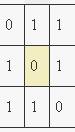

In [9]:
def cons_word_embedding(vectorized_sentences, window=2):
    # Determine the size of the vocabulary
    vocab_size = max(max(sentence) for sentence in vectorized_sentences) + 1

    # Initialize the co-occurrence matrix with zeros
    co_occurrence_matrix = np.zeros((vocab_size, vocab_size))

    for sentence in vectorized_sentences:
      sentence_length = len(sentence)
      for i, target_word in enumerate(sentence):
        # Define the context window boundaries
        start = max(0, i - window)
        end = min(sentence_length, i + window + 1)

        # Update the co-occurrence matrix within the context window
        for j in range(start, end):
          if j != i:
            co_occurrence_matrix[target_word][sentence[j]] += 1

    return co_occurrence_matrix

# Example usage
vectorized_sentences = [[0, 1, 2]]
window_size = 2
co_occurrence = cons_word_embedding(vectorized_sentences, window_size)
print(co_occurrence)


[[0. 1. 1.]
 [1. 0. 1.]
 [1. 1. 0.]]


Now that we have written the function, lets run our data through your pipeline and create the word embedding, you are free to make very small detail modifications to the code below, but **don't** change the overall structure.

In [10]:
cleaned_text_data = clean_sentences(text_data)
tokenized_sentences = tokenizer(cleaned_text_data)
mapping = sentences_to_mapping(tokenized_sentences)
vectorized_sentences = transform_vectorize(tokenized_sentences, mapping)
co_occurrence_word_embedding = cons_word_embedding(vectorized_sentences, window = 2)
print(co_occurrence_word_embedding)

[[164.  11. 820. ...   0.   1.   0.]
 [ 11.   0.   3. ...   0.   0.   0.]
 [820.   3.   8. ...   0.   0.   0.]
 ...
 [  0.   0.   0. ...   0.   0.   0.]
 [  1.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]]


### 1.5. Analyzing the Word Embeddings
Now that we have constructed our word embedding, it is time to analyze our construct. Answer the questions below


---
1.   Compare this approach to other methods such as TF-IDF and Deep Learning based Word Embeddings, how are they different? what are the advantages and the disadvantages of each approach?



**⏩ANSWER:**


#### Co-Occurrence-Based Word Embeddings
1. Methodology:

  These embeddings are generated by counting the frequency of word co-occurrences within a specified window in a large corpus. The resulting matrix encodes how words are likely to appear together.

2. Advantages:

  - **Interpretability**: Co-occurrence matrices are relatively easy to interpret. The values in the matrix represent word relationships.
  - **Simple to compute**: They are computationally less intensive compared to deep learning-based embeddings.

3. Disadvantages:

  - **Limited context**: Co-occurrence embeddings often work within a fixed context window, which might not capture long-range word associations.
  - **High dimensionality**: The co-occurrence matrix can be large, especially with a large vocabulary.


#### Deep Learning-Based Word Embeddings (Word2Vec, GloVe, etc.)

1. Methodology:

  These methods use neural networks to learn distributed representations of words based on the contexts in which they appear. Word2Vec, for example, creates word vectors that encode semantic similarity and relationships between words.

2. Advantages:

  - Captures rich semantic information and word relationships.
  - Effective in various NLP tasks, including sentiment analysis, machine translation, and text classification.
  - Can capture long-range dependencies between words.

3. Disadvantages
  - **Computationally expensive**: Training deep learning-based embeddings can be computationally intensive.
  - **Lack of interpretability**: These embeddings are challenging to interpret compared to simpler methods like co-occurrence matrices.
  - Requires large datasets: Deep learning-based embeddings benefit from large corpora.

In summary, Co-occurrence-based embeddings are simple and interpretable but have limitations in capturing long-range relationships. TF-IDF is effective for document-level tasks but does not provide rich word semantics. Deep learning-based embeddings excel in capturing word semantics and relationships but require large datasets and significant computational resources.

---



2.   How would you handle Out-of-Vocabulary words in this approach? Give 2 solutions and discuss their feasibility as well as their advantages and disadvantages.

**⏩ANSWER:**


#### 1. Subword Representations (e.g., FastText)

1. **Feasibility:**

  Highly feasible and widely used, with readily available tools like FastText.

2. **Advantages:**

  - **Coverage:** Effective for handling OOV words by breaking words into subword units (n-grams or character-level embeddings).
  - **Flexibility:** Can capture the morphological structure of words and handle unseen variations.
  - **Easy to implement:** Pre-trained models and libraries like FastText are available.

3. **Disadvantages:**

  - **Increased dimensionality:** Higher dimensionality compared to traditional word embeddings, leading to increased memory and computation requirements.
  - **Loss of word-specific meaning:** While effective at handling OOV words, subword embeddings might not fully capture the exact meaning of entire words.

#### 2. Special Tokens

1. **Feasibility:**

  Highly feasible and straightforward to implement by adding special tokens to the vocabulary.

2. **Advantages:**
  - **Explicit handling:** Provides an explicit and transparent way to deal with OOV words, allowing customization for different NLP tasks.
  - **Compatibility:** Can be used with any word embedding method, both traditional and deep learning-based embeddings.

3. **Disadvantages:**

  - **Limited semantic representation:** OOV words are represented by a special token, which may not capture their semantic meaning.
  - **Loss of information:** May not fully leverage the context of OOV words in the text, potentially leading to a loss of information.
  - **Contextual challenges:** Substituting OOV words with a special token may not be suitable for all NLP tasks, especially those where precise word meaning is crucial.

---

## Exercise 2: Correcting the Statistical Word Embedding
So far, we have managed to create our own word embedding, good job😁. In this part, we are going to discuss the shortcomings of our current approach and try to ameliorate it with some simple soltsions.

### 2.1. Problems with the Current Word Embedding

Answer the questions below

1 - Note that right now, each embedding of an arbitrary word is $N$ dimensional. Discuss why this can be a problem? Does an arbitrarily large word embedding result in better model performance? Discuss your answer and mention why you think your answer is the case.


---



**⏩ANSWER:**


**1. Curse of Dimensionality:**
   - **Problem**: Increasing the dimensionality of embeddings can lead to the curse of dimensionality. In high-dimensional spaces, the volume of the space becomes sparser, making it harder for models to generalize from limited data.
   - **Impact**: High-dimensional embeddings may require significantly more training data to avoid overfitting, and they can lead to increased computational and memory costs.

**2. Data Efficiency:**
   - **Problem**: Higher-dimensional embeddings may require larger datasets to train effectively. With limited data, it's challenging to estimate parameters accurately in high-dimensional spaces.
   - **Impact**: In scenarios where data is scarce, such as in specialized domains or for low-resource languages, larger embeddings might not be practical.

**3. Lack of Additional Information:**
   - **Problem**: Beyond a certain point, increasing the dimensionality doesn't necessarily provide more useful information about word relationships. Many semantic and syntactic patterns can be captured effectively in lower-dimensional embeddings.
   - **Impact**: Large embeddings may not lead to better model performance because they contain redundant or noisy information.

**4. Computation and Memory Costs:**
   - **Problem**: Larger embeddings require more memory to store and more computation during training and inference.
   - **Impact**: This can make models slower and less efficient, which can be a problem in production systems.

**5. Loss of Interpretability:**
   - **Problem**: Extremely high-dimensional embeddings can be challenging to interpret. Lower-dimensional embeddings are often preferred for their relative simplicity and interpretability.
   - **Impact**: In some applications, interpretability is important for understanding and debugging models.

**Why Smaller Dimensions Can Be Preferable:**

- **Data Efficiency**: Smaller-dimensional embeddings often generalize better from limited data, making them more suitable for tasks with smaller datasets.
- **Reduced Noise**: Smaller embeddings can have a lower noise-to-signal ratio, as they capture the most salient information about word relationships.
- **Computational Efficiency**: Smaller embeddings lead to faster model training and inference, which is essential for many real-world applications.

**Choosing the Right Dimensionality:**

The choice of embedding dimensionality is often task-dependent and requires experimentation. A common practice is to start with dimensions in the range of 100-300, which have been found to work well for many NLP tasks. Researchers often fine-tune the dimensionality based on the specific characteristics of their data and task.

In summary, while word embeddings with an arbitrary, extremely large dimension might capture more information, it can introduce problems related to data efficiency, computational costs, and interpretability. A well-balanced choice of dimensionality, which is often lower than arbitrary, is preferable in many practical NLP applications as it provides a good trade-off between performance and efficiency.


2 - Suppose that you have created a word embedding $W$ matrix from an arbitrary dataset. You now wish to use your dataset in a real Deep Learning model. Is it a good idea to further train your statistical word embedding in a downstream Deep Learning task? Why?




---



**⏩ANSWER:**

Fine-tuning or further training pre-trained word embeddings in a downstream deep learning task is a common and often beneficial practice, but whether it's a good idea depends on several factors. Here are some considerations:

**Advantages of Fine-Tuning Word Embeddings:**

1. **Domain-Specific Adaptation:** Fine-tuning allows the model to adapt the pre-trained embeddings to the specific domain and characteristics of your downstream task. This can help the model capture domain-specific semantics, which may not be present in the original pre-trained embeddings.

2. **Improved Task Performance:** Fine-tuning can lead to better performance in the downstream task, especially when the pre-trained embeddings are general and not domain-specific. It helps the model learn task-specific nuances and relationships between words.

3. **Reduced Dimensionality:** Fine-tuning can reduce the dimensionality of the embeddings by retaining only the most relevant dimensions for the task. This can lead to more efficient and memory-friendly models.

4. **Transfer of Pre-trained Knowledge:** The model retains valuable pre-trained linguistic knowledge while learning task-specific information, striking a balance between leveraging prior knowledge and adapting to new data.

**Considerations for Fine-Tuning Word Embeddings:**

1. **Task Specificity:** The decision to fine-tune word embeddings depends on the specificity of the downstream task. For highly domain-specific tasks, fine-tuning is often recommended. However, for tasks with generic language understanding requirements, you might not need to fine-tune the embeddings.

2. **Data Availability:** The availability of task-specific training data is crucial. Fine-tuning requires a sufficient amount of task-specific data to adapt the embeddings effectively. If you have a small dataset, fine-tuning may not be as beneficial and could lead to overfitting.

3. **Pre-trained Embedding Quality:** The quality of the pre-trained embeddings matters. High-quality embeddings from a large, diverse corpus are more likely to benefit from fine-tuning. If the pre-trained embeddings are noisy or poorly trained, fine-tuning might not yield significant improvements.

4. **Model Architecture:** The architecture of the downstream model also plays a role. Fine-tuning works well with models that are designed to accept word embeddings as part of their training process. Some models, like BERT, GPT, or ELMo, include embedding fine-tuning as a standard component.

5. **Computation Resources:** Fine-tuning can be computationally intensive, so you need to consider your available resources. Training larger models or fine-tuning embeddings can require substantial GPU power and memory.

In summary, whether it's a good idea to fine-tune word embeddings for a downstream deep learning task depends on the specific characteristics of your task, the quality of the pre-trained embeddings, data availability, and computational resources. When done correctly, fine-tuning can significantly improve the performance of your model, making it a valuable technique in many NLP applications.


### 2.2. Dimension Reduction

In this question, we wish to reduce the dimensionality of our word embeddings such that they are more in line with modern word embeddings.

Complete the function below such that given a word embedding of size $N \times N$, a word embedding of size $N \times X$ is returned with $X < N$.

Hint: For this purpose, explore  PCA and TruncatedSVD

In [11]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

def reduce_dimension(embeddings,dimension_reduction_techniques='svd', x=64):
  match dimension_reduction_techniques:
    case 'svd':
      model = TruncatedSVD(n_components=x)
    case 'pca':
      model = PCA(n_components=x)
    case default:
      model = TSNE(n_components=x)


  reduced_embeddings = model.fit_transform(embeddings)
  return reduced_embeddings

# Example usage
# Create a sample word embedding matrix (N x N)
N = 300  # Original dimension
X = 64  # Reduced dimension
sample_embeddings = np.random.rand(N, N)

# Reduce dimensionality
reduced_embeddings = reduce_dimension(sample_embeddings,'svd', X)
print(reduced_embeddings.shape)  # Output should be (N, X)


(300, 64)


### 2.3. Visualizing the word embeddings  

Remember that a good word embedding is a one that carries the meanings of the words in itself. Here, we want to visualize the word embedding that have created and analyze the spatial positions of each word.

Complete the function below such that given a word embedding matrix, the data points are plotted in a 2D space.

Hint: You have to use the "reduce_dimension" function to draw and the mapping that we created in the previous question to understand the mapping between data points and words.

Your final plot should be similar to this plot.

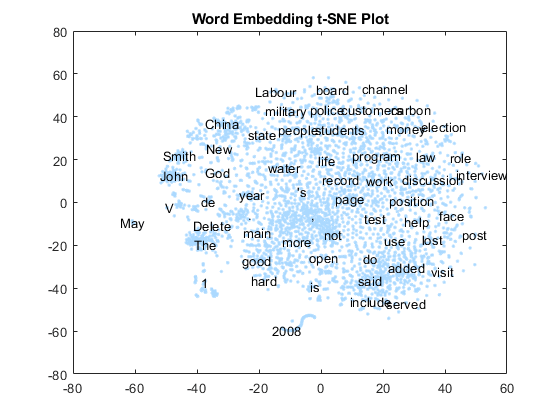

In [12]:
index_to_word = {v: k for k, v in mapping.items()}

In [13]:
def plot_reduced_embeddings(reduced_embeddings):
  # Create a scatter plot of the word embeddings
  plt.figure(figsize=(10, 10))
  for i, (x, y) in enumerate(reduced_embeddings[200:500]):
    r = 10
    if -r<x<r and -r<y<r:
      word = index_to_word[i]  #  index to word mapping
      plt.scatter(x, y)
      plt.text(x, y, word, fontsize=12, alpha=0.5)

  plt.title("Word Embeddings in 2D Space")
  plt.xlabel("Dimension 1")
  plt.ylabel("Dimension 2")
  plt.grid()
  plt.show()

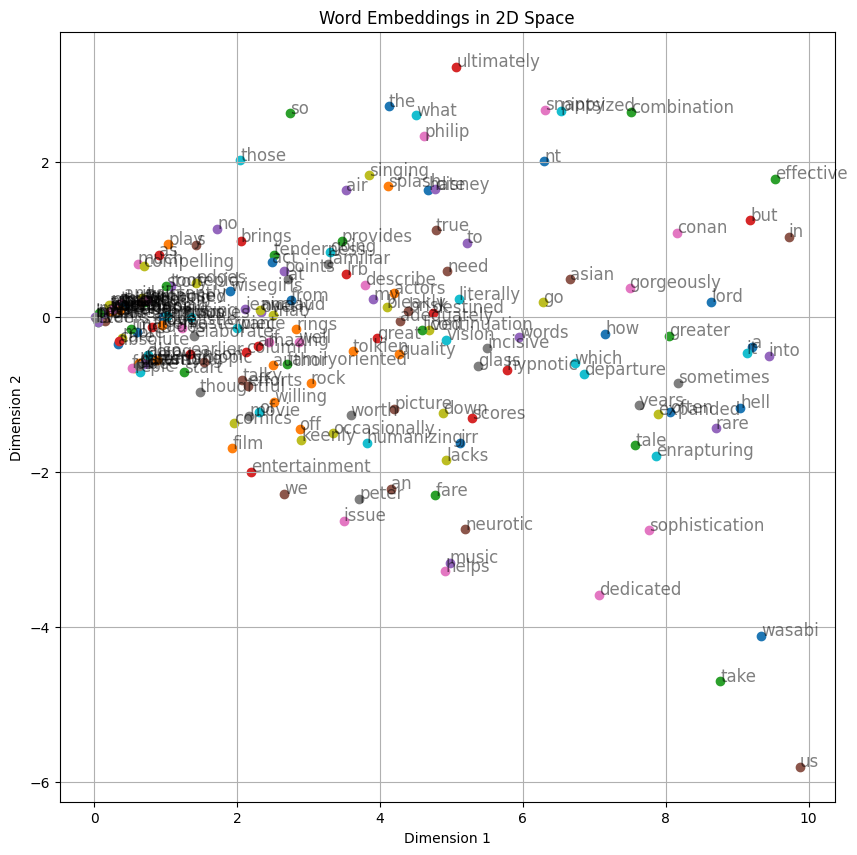

In [14]:
# Reduce the dimensionality to 2D with svd
reduced_embeddings = reduce_dimension(co_occurrence_word_embedding, 'svd', x=2)

plot_reduced_embeddings(reduced_embeddings)

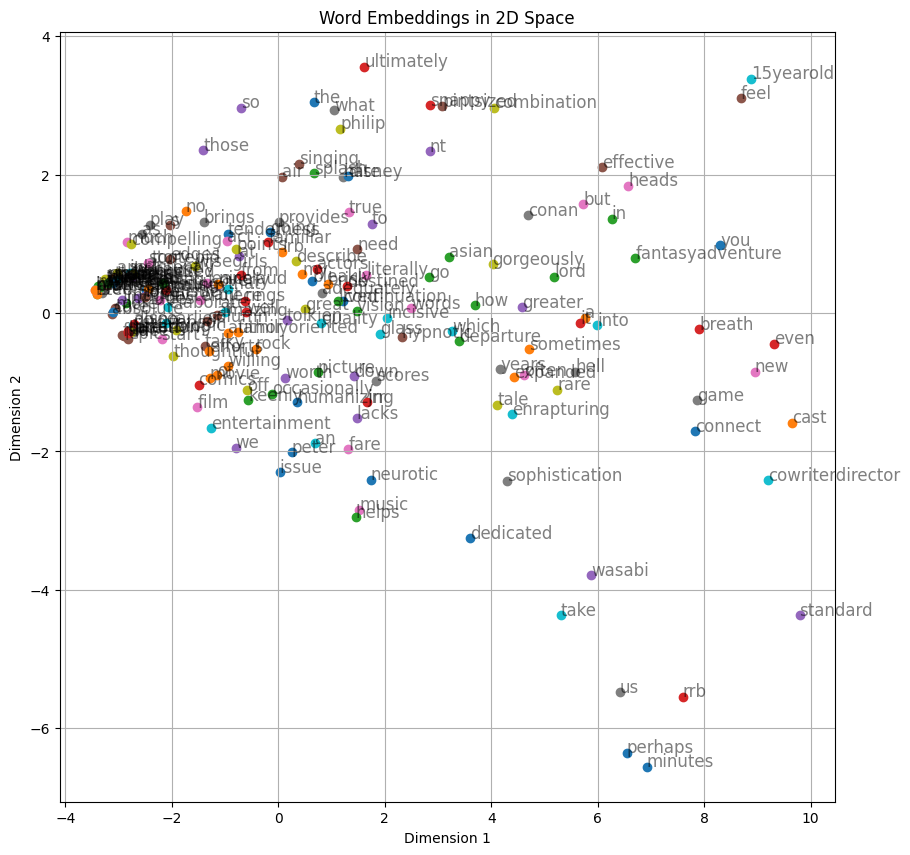

In [15]:
# Reduce the dimensionality to 2D with pca
reduced_embeddings = reduce_dimension(co_occurrence_word_embedding, 'pca', x=2)

plot_reduced_embeddings(reduced_embeddings)

Having visualized our word embedding, it is easier to analyze its properties and talk about its qualities.

Answer the questions below based on your plot.



1.   What words are clustered together? What words are not? give 3 pairs of words that you think are correctly clustered together and 3 pairs of words that you think should be clustered together but are not.



---



**⏩ANSWER:**
The mode in which we have used SVD to reduce the dimension;
  clustered: (greater-lord) - (movie-comics) - (sometimes-rare)
  
  should be clustered: (into-to) - (an-the) - (great-greater)


2.   Why do you think some related words are not clustered together? How do you think we can solve this problem?



---



**⏩ANSWER:**

The phenomenon of related words not being closely clustered together in word embeddings can be attributed to several factors. Understanding these factors can help in addressing the issue:

1. **Polysemy and Homonymy:** Words with multiple meanings (polysemous) or words that sound the same but have different meanings (homonymous) can create dispersion. For example, the word "bank" can refer to a financial institution or the side of a river. Embeddings often represent these different meanings in separate regions of the space.

2. **Contextual Variability:** The meaning of a word can vary depending on the context. Word embeddings are typically trained on large corpora, and they may not capture context-specific meanings, leading to dispersion. For example, the word "apple" can refer to a fruit or a technology company.

3. **Data Sparsity:** For less frequent or specialized words, word embeddings may not have enough context to accurately position them in the embedding space. This can result in dispersion for rare or domain-specific terms.

4. **Embedding Dimensionality:** The dimensionality of word embeddings can affect clustering. Lower-dimensional embeddings may not capture fine-grained semantic relationships, while high-dimensional embeddings can be noisy.

To address the problem of related words not being closely clustered together:

1. **Contextualized Embeddings:** Consider using contextualized embeddings like ELMo, BERT, or GPT-3, which model word meanings based on the surrounding context. These models capture different meanings and disambiguate polysemous words more effectively.

2. **Fine-Tuning:** Fine-tune word embeddings or pre-trained language models on domain-specific data to align them with the context of your application. This can help related words cluster more closely for your specific use case.

3. **Dimensionality Reduction:** Experiment with dimensionality reduction techniques, such as PCA or t-SNE, to visualize and analyze word embeddings in lower-dimensional spaces. This can help reveal clustering patterns and facilitate manual adjustments.

4. **Contextual Analysis:** Consider analyzing the context in which words are used. Studying word co-occurrence patterns and context can provide insights into why certain words are dispersed and help you refine your embeddings.

5. **Data Augmentation:** Augment your data with additional context or domain-specific examples to improve the representation of words. This can help address data sparsity issues.

6. **Manual Adjustment:** For specific applications, you can manually adjust word embeddings to ensure that related words are closer in the vector space. However, this approach is labor-intensive and requires domain expertise.

7. **Evaluation Metrics:** Use evaluation metrics like word similarity and word analogy tests to assess the quality of your embeddings. This can help identify issues and areas for improvement.

8. **Domain-Specific Pre-training:** If your task involves a specific domain (e.g., medical or legal), consider pre-training embeddings on domain-specific corpora to capture domain-specific semantics.




## Exercise 3: Explore Pre-trained Word Embeddings


### 3.1 Loading & Exploration:

As you know Word embeddings are dense vector representations of words in a continuous vector space. Instead of building these embeddings from scratch, which can be computationally intensive and require a significant amount of data, pretrained word embeddings offer an efficient alternative. They are generated using vast amounts of text data and then made available for public use.

Load the GloVe embeddings using the gensim library.
Choose three words of your preference. For each of these words, retrieve and display the top 5 words that are most similar based on the embeddings. Use cosine similarity as your metric.


In [16]:
import gensim.downloader as api
# Download and load the Word2Vec model.

word_vectors = api.load('glove-twitter-25')


[==================================================] 100.0% 104.8/104.8MB downloaded


In [17]:
# Define three words of interest
words_of_interest = ["king", "queen", "computer"]

In [18]:
# Retrieve and display the top 5 most similar words for each word
similar_words = {}
for word in words_of_interest:
    if word in word_vectors:
        most_similar = word_vectors.most_similar(word, topn=5)
        similar_words[word] = most_similar

In [19]:
# Display the results
for word, similar in similar_words.items():
    print(f"Words similar to '{word}':")
    for w, sim in similar:
        print(f"{w}: {sim:.4f}")
    print()

Words similar to 'king':
prince: 0.9337
queen: 0.9202
aka: 0.9177
lady: 0.9163
jack: 0.9147

Words similar to 'queen':
princess: 0.9394
lady: 0.9336
prince: 0.9269
king: 0.9202
aka: 0.8977

Words similar to 'computer':
camera: 0.9078
cell: 0.8919
server: 0.8745
device: 0.8694
wifi: 0.8631



### 3.2 Visualization:

We have a set of 8 selected words which should include a mix of:
Words with clear gender associations (e.g., 'king', 'queen').
Words related to technology (e.g., 'computer', 'keyboard').
Words representing geographical entities (e.g., 'city', 'town').

You can select your own words based on the explanation above.

In [20]:
words = ['king', 'queen', 'man', 'woman', 'computer', 'keyboard', 'city', 'town']

Use Principal Component Analysis (PCA) to reduce the dimensionality of these word embeddings to 2D.
Visualize these 2D embeddings on a scatter plot, ensuring each word is labeled on the graph.

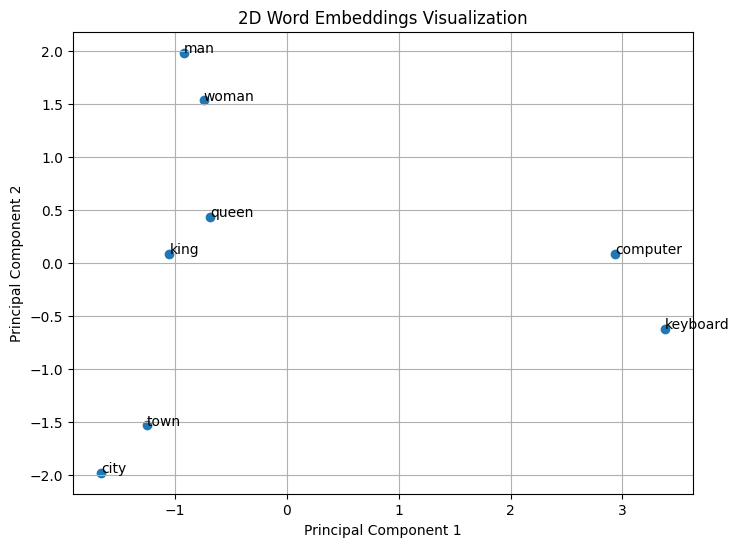

In [21]:
# Retrieve the word vectors for the selected words
word_embeddings = [word_vectors[word] for word in words]

# Apply PCA to reduce dimensionality to 2D
pca = PCA(n_components=2)
word_embeddings_2d = pca.fit_transform(word_embeddings)

# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(word_embeddings_2d[:, 0], word_embeddings_2d[:, 1])

# Label each point with the corresponding word
for i, word in enumerate(words):
    plt.annotate(word, (word_embeddings_2d[i, 0], word_embeddings_2d[i, 1]))

plt.title('2D Word Embeddings Visualization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid()
plt.show()



Do the same visualization with same words using the word embedding that you created in exercise 1.

In [22]:
vocab = mapping.keys()
glove_emmbeding_vocab = np.array([word_vectors[word] for word in vocab if word in word_vectors])

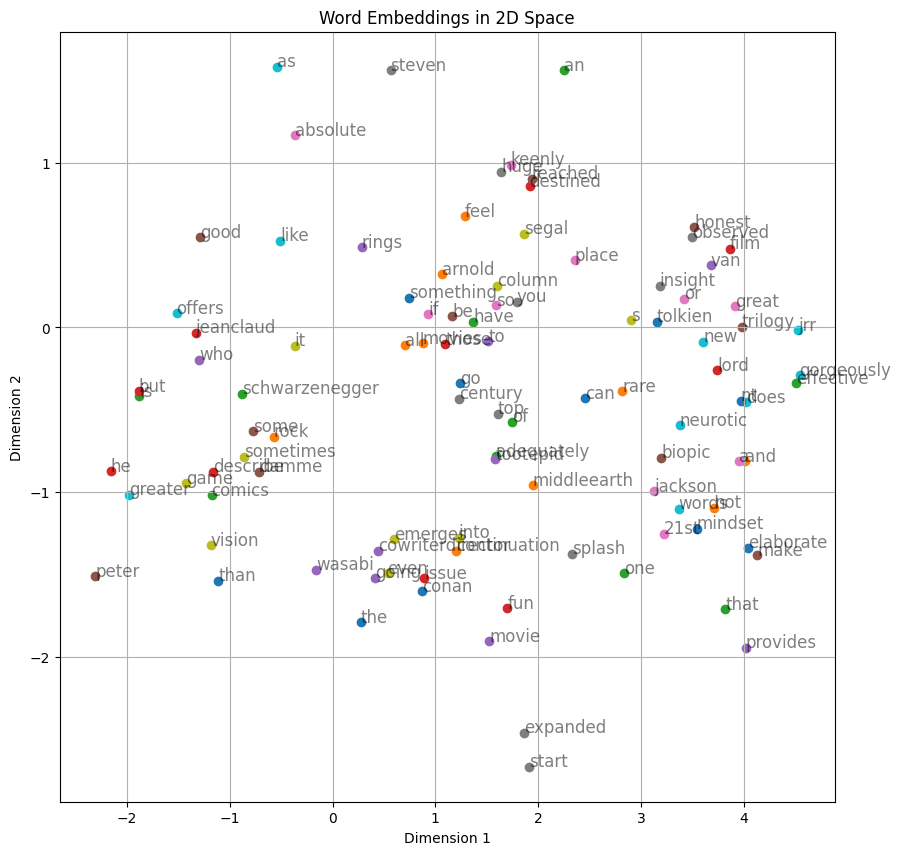

In [23]:
reduced_embeddings = reduce_dimension(glove_emmbeding_vocab, 'pca', x=2)
plt.figure(figsize=(10, 10))
for i, (x, y) in enumerate(reduced_embeddings[200:300]):
  # r = 10
  # if -r<x<r and -r<y<r:
  word = index_to_word[i]  # Assuming you have the index_to_word mapping
  plt.scatter(x, y)
  plt.text(x, y, word, fontsize=12, alpha=0.5)

plt.title("Word Embeddings in 2D Space")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.grid()
plt.show()

### 3.3 Interpretation :

Based on the visualization, describe any observed clusters or relationships among the words. What might be the reason for such relationships or patterns?


---



**⏩ANSWER:**

Clusters in the scatter plots:
1. (man, woman)
2. (town, city)
3. (key, computer)
4. (queen, king)

These groups of words are connected in meaning, and they can be linked by a common topic, synonymy, or shared attributes.

For instance, "town" and "city" are synonyms, "man" and "woman" represent genders, and "key" and "computer" are related as digital components.

Explain the difference between these two scatter plot in section 3.2.



---



**⏩ANSWER:**
It's evident that word2vec embeddings excel at capturing semantic relationships, resulting in closer proximity between semantically related words, outperforming our embedding method in this regard.





## Exercise 4: Dive into Hugging Face and Transformers

In this exercise, we'll explore the world of Hugging Face, a leading platform in natural language processing, and its Transformers library. Transformers have revolutionized the way we handle text data in machine learning. We'll specifically focus on fine-tuning a transformer model for a sentiment analysis task. Dive in to grasp the intricacies of these powerful models and their applications!

### 4.1 Getting Started with Transformers:

Install the transformers library and import the necessary modules.


In [24]:
#install transformer library
!pip install transformers


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 37.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 43.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 49.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 35.5 MB/s eta 0:00:00


In [44]:
import torch
if torch.cuda.is_available():
    device_name = torch.device("cuda")
else:
    device_name = torch.device('cpu')
print("Using {}.".format(device_name))

Using cuda.


Choose a pretrained model (like BERT) from Hugging Face's model hub. Load the model and its corresponding tokenizer. What architecture does the chosen model belong to? Provide a brief overview of its main features.


---



**⏩ANSWER:**

The BERT (Bidirectional Encoder Representations from Transformers) model belongs to the Transformers architecture.
**Main Features**:

1. **Bidirectional Context**: BERT introduced bidirectionality to pre-trained language models. It can capture the entire context of a word in a sentence by considering both left and right context. This is in contrast to earlier models, such as LSTMs and traditional Transformers, which are unidirectional or restricted in their context window.

2. **Pre-training**: BERT is pre-trained on a large corpus of text by learning to predict missing words in sentences. This pre-training phase enables the model to capture a wide range of language understanding, including syntax, semantics, and world knowledge. BERT's architecture involves the use of a transformer encoder with multiple layers.

3. **Fine-Tuning**: BERT can be fine-tuned for various downstream natural language processing (NLP) tasks. By adding task-specific layers on top of the pre-trained model and training on task-specific data, BERT can adapt to specific tasks like text classification, named entity recognition, question-answering, and more.

4. **Embedding Tokens**: BERT uses subword tokenization, such as WordPiece or SentencePiece, which allows it to represent a wide vocabulary efficiently. It can represent out-of-vocabulary words by breaking them into subword units.

5. **Masked Language Model**: During pre-training, BERT learns to predict masked words within sentences. This is achieved by randomly masking some words in the input and training the model to predict those masked words.

6. **Segment Embeddings**: BERT can handle text with multiple sentences or segments by using segment embeddings. This allows it to understand the relationships and dependencies between different segments of text.

7. **Positional Embeddings**: BERT incorporates positional embeddings to understand the order of words within a sentence, ensuring that it captures sequential information.

8. **State-of-the-Art Performance**: BERT has achieved state-of-the-art results on a wide range of NLP tasks, setting new benchmarks for tasks like natural language inference, sentiment analysis, machine translation, and more.

In [45]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
# Define the model name
model_name = "bert-base-uncased"

# Load the corresponding tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Load the model
model = AutoModelForSequenceClassification.from_pretrained(model_name).to(device_name)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### 4.2 Tokenization:

Use the tokenizer you've loaded to tokenize the sentences that are in the sentences list and print the tokens.

In [37]:
sentences = ["Transformers have revolutionized NLP.",
             "Hugging Face provides an amazing platform for pretrained models."]

# Tokenize the sentences and print the tokens
for sentence in sentences:
    tokens = tokenizer.tokenize(sentence)
    print(f"Sentence: {sentence}")
    print("Tokens:", tokens)
    print()


Sentence: Transformers have revolutionized NLP.
Tokens: ['transformers', 'have', 'revolution', '##ized', 'nl', '##p', '.']

Sentence: Hugging Face provides an amazing platform for pretrained models.
Tokens: ['hugging', 'face', 'provides', 'an', 'amazing', 'platform', 'for', 'pre', '##train', '##ed', 'models', '.']



Explain the significance of the following components in the tokenized output: input_ids, attention_mask, and token_type_ids.


---



**⏩ANSWER:**


1. **input_ids** are numerical representations of the tokens in the input text. Each token is mapped to a unique integer ID based on the model's vocabulary. This component allows the model to understand and process the text as numerical data.
  

2. **attention_mask** is used to specify which tokens in the input should be attended to and which tokens should be ignored. It helps the model focus on relevant information and avoid processing padding tokens or special tokens like [PAD].


3. **token_type_ids** are used in models that accept multiple segments or sentences as input (e.g., for tasks like question-answering or text generation). They indicate which segment each token belongs to, helping the model differentiate between different parts of the input text.

### 4.3 Fine-tuning and Classification:

Using Hugging Face's datasets library, load a sentiment classification dataset of your choice.

In [38]:
!pip install datasets

In [46]:
from datasets import load_dataset

# Load IMDb dataset for sentiment classification
dataset = load_dataset("imdb")

imdb_train = dataset["train"].shuffle(seed=43)
imdb_test = dataset["test"].shuffle(seed=43)

Tokenize the dataset and prepare it for training.

In [50]:
# Tokenize the dataset
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

# Apply the tokenize function to the dataset using map
tokenized_train = imdb_train.map(tokenize_function, batched=True)
tokenized_test = imdb_test.map(tokenize_function, batched=True)

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Fine-tune the pretrained model you've chosen on this dataset for sentiment classification.

Report the evaluation metrics(accuracy, precision and recall) on a held-out test set.

you can set the hyperparameters on your choice.

In [51]:
# Load model


# Train the model


# Evaluate the model


In [52]:
! pip install -U accelerate
! pip install -U transformers

In [53]:
import torch
from transformers import TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, precision_score, recall_score
from transformers import DataCollatorWithPadding

# Define a function for computing metrics
def compute_metrics(p):
    preds = p.predictions.argmax(-1)
    return {
        "accuracy": accuracy_score(p.label_ids, preds),
        "precision": precision_score(p.label_ids, preds),
        "recall": recall_score(p.label_ids, preds),
    }

# Define training arguments
training_args = TrainingArguments(
    output_dir="./sentiment_model",
    evaluation_strategy="steps",
    eval_steps=500,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    save_total_limit=2,
    push_to_hub=False,
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=DataCollatorWithPadding(tokenizer),
    compute_metrics=compute_metrics,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
)

# Train the model
trainer.train()

# Evaluate the model
results = trainer.evaluate()

# Print evaluation metrics
print("Accuracy:", results["eval_accuracy"])
print("Precision:", results["eval_precision"])
print("Recall:", results["eval_recall"])


ImportError: ignored

### 4.4 Exploration:

Choose a task other than sentiment classification (e.g., named entity recognition, question answering). Load a pretrained model suitable for this task from Hugging Face's model hub.

Provide a brief overview of how the model is structured to handle this specific task and give an example of its usage.


---



**⏩ANSWER:**

choose the task of **Named Entity Recognition (NER)**. NER task of identifying and classifying named entities in text, such as names of persons, organizations, dates, and more.




In [ ]:
from transformers import AutoModelForTokenClassification, AutoTokenizer

# Load the BERT model fine-tuned for NER
model_name = "dbmdz/bert-large-cased-finetuned-conll03-english"
model = AutoModelForTokenClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)



overview of how the model is structured for NER:

1. **BERT (Bidirectional Encoder Representations from Transformers)**:
   - The underlying architecture of the model is based on BERT, a transformer-based architecture. BERT is a bidirectional model that captures contextual information by considering both left and right context for each token in the input text.

2. **Token Classification Head**:
   - To adapt BERT for NER, the model has a specialized token classification head. This head is responsible for assigning a label to each token in the input sequence, indicating whether the token belongs to an entity and, if so, what type of entity it is.


In [ ]:
from transformers import pipeline

# Load the NER pipeline using the fine-tuned model
nlp_ner = pipeline("ner", model=model, tokenizer=tokenizer)

# Example text for NER
text = "Apple Inc. was founded by Steve Jobs in Cupertino, California."

# Perform NER on the text
ner_results = nlp_ner(text)

# Print the named entities and their labels
for entity in ner_results:
    print(f"Entity: {entity['word']}, Label: {entity['entity']}")
